# Problema

A taxa de churn representa o percentual de clientes que deixam de utilizar os serviços de uma empresa em um determinado período. No contexto de uma empresa de telecomunicações, o churn corresponde, por exemplo, aos clientes que cancelam seu plano de internet ou de telefonia móvel.

De forma geral, podemos classificar o churn em dois grandes grupos:


* Churn involuntário: Ocorre por fatores externos à vontade do cliente, como a interrupção de serviços em determinada região (ex.: a empresa decide encerrar operações em um bairro) ou o cancelamento por inadimplência devido a atrasos ou falta de pagamento.

* Churn voluntário: Resulta da decisão consciente do cliente em encerrar o serviço. As principais razões incluem insatisfação com a qualidade, migração para concorrentes com melhores preços ou planos, ou até mesmo dificuldades financeiras.

Entender o perfil dos clientes que churnam é fundamental para criar estratégias de retenção e melhorar a experiência do usuário.

O objetivo deste trabalho é identificar atributos que possam estar influenciando na alta do churn em uma empresa de telecom.

# Imports

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Extração

In [ ]:
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json"  # Raw URL
df_raw = pd.read_json(url)
df_raw.head(3)

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


## Normalizando o dataframe e padronizando colunas

In [ ]:
# df_normalized = df_n
df_n = df_raw.copy()

df_n = df_n.join(pd.json_normalize(df_n['customer']))
df_n = df_n.join(pd.json_normalize(df_n['phone']))
df_n = df_n.join(pd.json_normalize(df_n['internet']))
df_n = df_n.join(pd.json_normalize(df_n['account']))

# Remove as colunas originais que eram dicionários
df_n.drop(['customer', 'phone', 'internet', 'account'], axis=1, inplace=True)

df_n.head(1)

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3


In [ ]:
df_n = df_n.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender', 'tenure': 'Tenure', 'Charges.Monthly': 'ChargesMonthly','Charges.Total': 'ChargesTotal'})
df_n.head(1)

,CustomerID,Churn,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,ChargesMonthly,ChargesTotal
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3


## Dicionário de dados

Dicionário de dados
* `CustomerID`: número de identificação único de cada cliente
* `Churn`: se o cliente deixou ou não a empresa
* `Gender`: gênero (masculino e feminino)
* `SeniorCitizen`: informação sobre um cliente ter ou não idade igual ou maior que 65 anos
* `Partner`: se o cliente possui ou não um parceiro ou parceira
* `Dependents`: se o cliente possui ou não dependentes
* `Tenure`: meses de contrato do cliente
* `PhoneService`: assinatura de serviço telefônico
* `MultipleLines`: assisnatura de mais de uma linha de telefone
* `InternetService`: assinatura de um provedor internet
* `OnlineSecurity`: assinatura adicional de segurança online
* `OnlineBackup`: assinatura adicional de backup online
* `DeviceProtection`: assinatura adicional de proteção no dispositivo
* `TechSupport`: assinatura adicional de suporte técnico, menos tempo de espera
* `StreamingTV`: assinatura de TV a cabo
* `StreamingMovies`: assinatura de streaming de filmes
* `Contract`: tipo de contrato
* `PaperlessBilling`: se o cliente prefere receber online a fatura
* `PaymentMethod`: forma de pagamento
* `ChargesMonthly`: total de todos os serviços do cliente por mês
* `ChargesTotal`: total gasto pelo cliente

# Transformação

## Análise dos tipos de dados e correções

In [ ]:
print(f'Variáveis do dataset: {df_n.shape[1]}\nTotal de linhas do dastaset: {df_n.shape[0]}\n')

Variáveis do dataset: 21
Total de linhas do dastaset: 7267



In [ ]:
df_n.dtypes

,0
CustomerID,object
Churn,object
Gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
Tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object


In [ ]:
# notei que a coluna ChargesTotal não está como float como deveria ser, portanto corrijo ela
df_n['ChargesTotal'] = pd.to_numeric(df_n['ChargesTotal'], errors='coerce')

## Análise de nulos e correções

In [ ]:
# verficando valores nulos. Existem 11 casos na coluna ChargesTotal.
df_n.isnull().sum()

,0
CustomerID,0
Churn,0
Gender,0
SeniorCitizen,0
Partner,0
Dependents,0
Tenure,0
PhoneService,0
MultipleLines,0
InternetService,0


In [ ]:
# Eu poderia preencher eles com a média, mas vou dropar essas linhas por representarem apenas 0,1% da amostra.
df_n = df_n.dropna(subset=['ChargesTotal'])
print(f'Total de valores vazios na variável TotalCharges após o tratamento é de: {df_n["ChargesTotal"].isnull().sum()}.\
      \nO total de linhas do dataset é: {df_n.shape[0]}')

Total de valores vazios na variável TotalCharges após o tratamento é de: 0.      
O total de linhas do dataset é: 7256


## Valores únicos das colunas categóricas

Aqui é possível notar que na coluna churn existe o valor vazio ''. Como esse valor não está preenchido e é um valor determinante, eu excluo os registro do dataset.

Ao todo são 224 casos.

In [ ]:
# imprimindo os valores únicos das colunas não numéricas e excluindo a primeira coluna de Id
colunas = df_n.columns.tolist()[1:]
for coluna in colunas:
  if df_n[coluna].dtype == 'object':
    print(f'Coluna {coluna}: {df_n[coluna].unique()}')


Coluna Churn: ['No' 'Yes' '']
Coluna Gender: ['Female' 'Male']
Coluna Partner: ['Yes' 'No']
Coluna Dependents: ['Yes' 'No']
Coluna PhoneService: ['Yes' 'No']
Coluna MultipleLines: ['No' 'Yes' 'No phone service']
Coluna InternetService: ['DSL' 'Fiber optic' 'No']
Coluna OnlineSecurity: ['No' 'Yes' 'No internet service']
Coluna OnlineBackup: ['Yes' 'No' 'No internet service']
Coluna DeviceProtection: ['No' 'Yes' 'No internet service']
Coluna TechSupport: ['Yes' 'No' 'No internet service']
Coluna StreamingTV: ['Yes' 'No' 'No internet service']
Coluna StreamingMovies: ['No' 'Yes' 'No internet service']
Coluna Contract: ['One year' 'Month-to-month' 'Two year']
Coluna PaperlessBilling: ['Yes' 'No']
Coluna PaymentMethod: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']


In [ ]:
len(df_n[df_n['Churn'] == ''])

224

In [ ]:
_churn_vazio = len(df_n[df_n['Churn'] == ''])
_comprimento_df = len(df_n)
print(f'Temos {_churn_vazio} linhas sem valor na coluna Churn de um total de {_comprimento_df} linhas.')

Temos 224 linhas sem valor na coluna Churn de um total de 7256 linhas.


In [ ]:
df_n = df_n[df_n['Churn'] != '']

_comprimento_df = len(df_n)
_churn_vazio = len(df_n[df_n['Churn'] == ''])
print(f'Temos {_churn_vazio} linhas sem valor na coluna Churn de um total de {_comprimento_df} linhas.')

Temos 0 linhas sem valor na coluna Churn de um total de 7032 linhas.


## Indicadores estatísticos das colunas numéricas

In [ ]:
# describe das colunas numéricas
df_n.describe()

,SeniorCitizen,Tenure,ChargesMonthly,ChargesTotal
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


# Carga e análise

## Correlação entre colunas com a variável churn

O método [get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) transforma os valores categóricos em números *( variáveis dummies também chamadas de one-hot encoded)* e a partir daí fazemos uma correlação.

As variáveis dummies são colunas binárias que representam a presença de cada categoria de uma variável categórica.

    No gráfico podemos notar uma correlação positiva com o churn quando o Contrato é mês a mês, OnlineSecurity e TechSupport = não.

    Enquanto temos uma correlação negativa com o churn quando o cliente tem um Tenure alto e contrato = 2 anos.

    As colunas de Gender, PhoneService, MultipleLines, StreamingMovies, StreamingTV possuem correlação bem perto de zero.
    Isso pode indicar que são pouco influentes na decisão do Churn.

  Verificaremos essas informações adiante



In [ ]:
df_dummies = df_n.copy()
df_dummies = df_dummies.drop(['CustomerID'], axis=1)
# converter o churn em valor numérico antes de aplicar o dummies
df_dummies['Churn'] = df_n['Churn'].replace({'Yes': 1, 'No': 0})
df_dummies = pd.get_dummies(df_dummies, dtype=int)
df_dummies.head(3)

,Churn,SeniorCitizen,Tenure,ChargesMonthly,ChargesTotal,Gender_Female,Gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,9,65.6,593.30,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
1,0,0,9,59.9,542.40,0,1,1,0,1,...,1,1,0,0,1,0,0,0,0,1
2,1,0,4,73.9,280.85,0,1,1,0,1,...,0,1,0,0,0,1,0,0,1,0


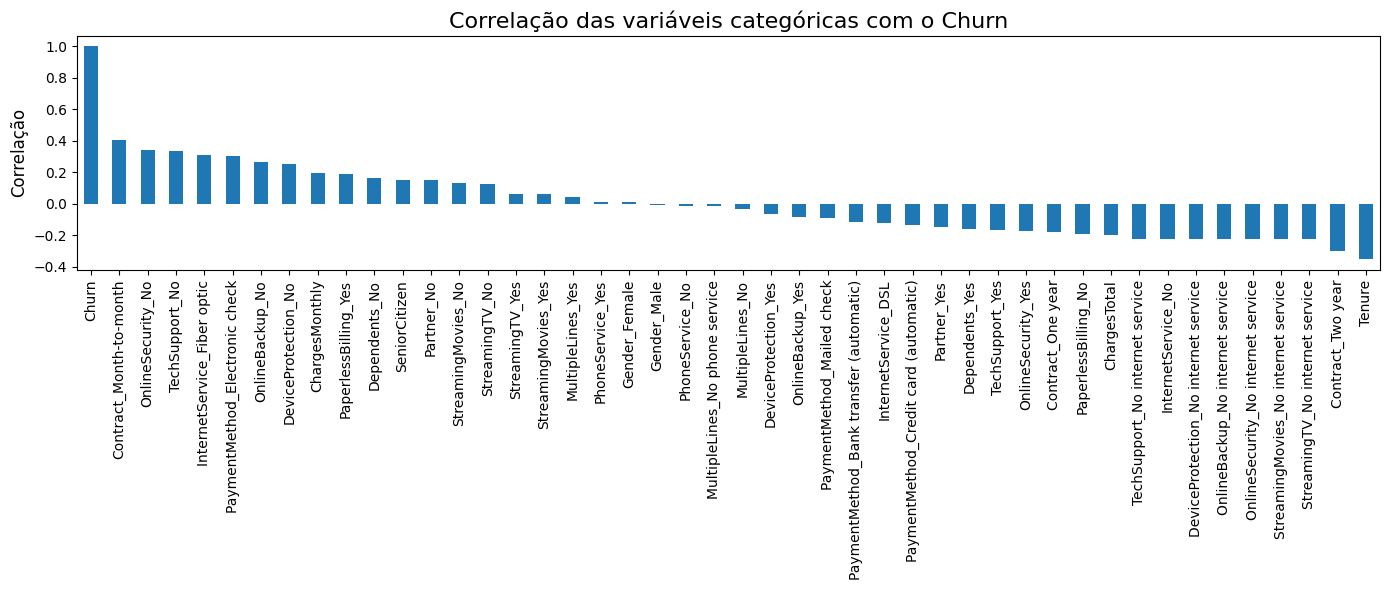

In [ ]:
plt.figure(figsize=(14,6))
df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')
plt.ylabel('Correlação', fontsize=12)
plt.title('Correlação das variáveis categóricas com o Churn', fontsize=16)
plt.tight_layout()
#plt.xticks(rotation=45, ha='right')
plt.show();

## Taxa de churn

Após limpar a base, temos 73,42% da base ainda ativa e 26,58% que não são mais clientes.

In [ ]:
percentual_churn = round((df_n['Churn'].value_counts(normalize=True) * 100),2)
percentual_churn = percentual_churn.rename("Percentual %").reset_index()

fig = px.bar(percentual_churn, x='Churn', y='Percentual %', color='Churn')
fig.update_layout(title='Taxa de Churn',title_x=0.5,autosize=False,width=1200,height=450)
fig.show()

## Churn por tenure

Podemos notar em ambos os gráficos que a maior quantidade de pessoas que evadem da empresa possuem poucos meses que são clientes.

A mediana dos clientes que evadem é de 10 meses, enquanto de quem ainda é cliente é de 38 meses.

In [ ]:
fig = px.box(df_n, x="Churn", y="Tenure", color="Churn")
fig.update_layout(title='Qtd de Churn por Tenure',title_x=0.5,autosize=False,width=1200,height=500)
fig.show()

In [ ]:
churn_tenure = df_n.groupby(['Churn'])['Tenure'].value_counts().reset_index().rename(columns={"count":"Qtd Churn"})
fig = px.bar(churn_tenure, x='Tenure', y='Qtd Churn', color='Churn')
fig.update_layout(title='Qtd de Churn por Tenure',title_x=0.5,autosize=False,width=1200,height=500)
fig.show()

In [ ]:
# churn_tenure = round(df_n.groupby('Churn')['Tenure'].value_counts(normalize=True).mul(100).reset_index(name='Percentual'),2)

# fig = px.bar(churn_tenure, x='Tenure', y='Percentual', color='Churn')
# fig.update_layout(title='Percentual de Churn por Tenure',title_x=0.5,autosize=False,width=1200,height=500)
# fig.show()

## Taxa de churn por contrato

Podemos observar que 88% do churn está localizado em contratos mês a mês, o que pode significar que um cliente sem um contrato com fidelidade está mais sujeito ao churn.

In [ ]:
churn_contrato = round(df_n.groupby('Churn')['Contract'].value_counts(normalize=True).mul(100).reset_index(name='Percentual'),2).sort_values(by='Contract')
fig = px.bar(churn_contrato, x='Contract', y='Percentual', color='Churn', barmode='group')
fig.update_layout(title='Taxa de Churn por Contrato', title_x=0.5, autosize=False, width=1200, height=500)
fig.show()

In [ ]:
# agrupado 100%
# churn_contrato = round(df_n.groupby('Contract')['Churn'].value_counts(normalize=True).mul(100).reset_index(name='Percentual'),2).sort_values(by='Contract')
# fig = px.bar(churn_contrato, x='Contract', y='Percentual', color='Churn')
# fig.update_layout(title='Taxa de Churn por contrato', title_x=0.5, autosize=False, width=1200, height=500)
# fig.show()

## Taxa de Churn por senioridade

Quando olhamos para a taxa absoluta, a maior parte do churn está concentrada em clientes não sêniors, pois também são a maior parte da base.
A relação de clientes seniores é de 12,9% da base enquanto o churn é de 24,5% algo que pode ser importante acompanhar, mas devido a baixa representividade na base pode ser algo que seja atacado posteriormente.




In [ ]:
churn_senioridade = round(df_n.groupby('Churn')['SeniorCitizen'].value_counts(normalize=True).mul(100).reset_index(name='Percentual'),2).sort_values(by='SeniorCitizen')
#churn_senioridade = df_n.groupby(['Churn'])['SeniorCitizen'].value_counts().reset_index().rename(columns={"count":"Qtd Churn"})
#churn_senioridade = round(df_n.groupby('SeniorCitizen')['Churn'].value_counts(normalize=True).mul(100).reset_index(name='Percentual'),2).sort_values(by='SeniorCitizen')
churn_senioridade['SeniorCitizen'] = churn_senioridade['SeniorCitizen'].replace({1: 'Senior', 0: 'Outras idades'})
fig = px.bar(churn_senioridade, x='SeniorCitizen', y='Percentual', color='Churn',barmode='group')
fig.update_layout(title='Taxa de Churn por Senioridade', title_x=0.5, autosize=False, width=1200, height=500)
fig.show()

## Churn em relação às contas mensais

Tanto no histograma quanto no gráfico de densidade é possível notar que a maior parte do churn está contida nas contas mensais com alto valor.

In [ ]:
df_churn_monthly_charge = df_n[['Churn','ChargesMonthly']]
fig = px.histogram(df_churn_monthly_charge, x='ChargesMonthly', color='Churn', nbins=60)
fig.update_layout(title='Distribuição do valor das contas mensais e Churn',title_x=0.5,autosize=False,width=1200,height=500, yaxis_title='Qtd')
fig.show()

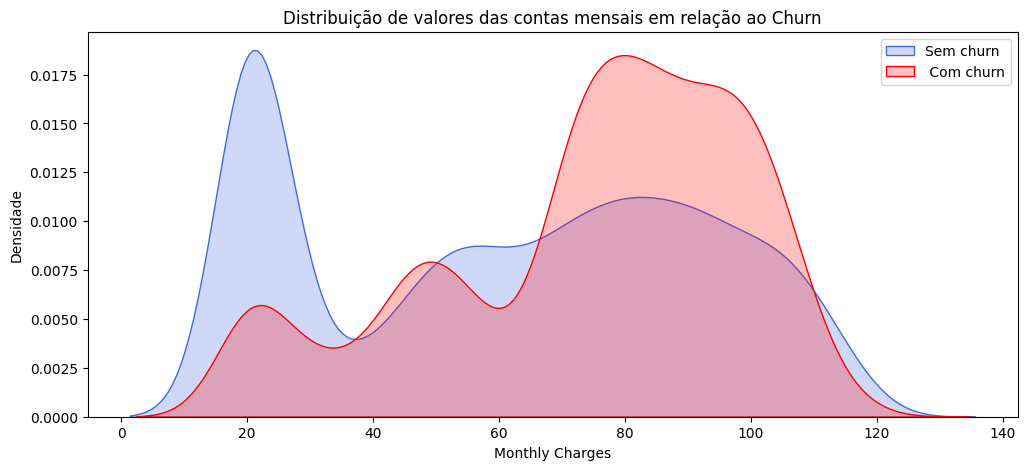

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(12, 5))
ax = sns.kdeplot(df_n.ChargesMonthly[(df_n['Churn']=='No')],
                 color='royalblue', shade = True)

ax = sns.kdeplot(df_n.ChargesMonthly[(df_n['Churn']=='Yes')],
                 color='red', shade = True)

ax.legend(["Sem churn"," Com churn"],loc='upper right')
ax.set_ylabel('Densidade')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribuição do valor das contas mensais em relação ao Churn');

## Churn em relação às contas totais

Tanto no gráfico histograma quanto no de densidade, o churn está concentrado nas contas totais menores.

Se olharmos só esse gráfico podemos ter uma interpretação equivocada. Mas sabendo que o churn está mais concentrado em clientes com um baixo tenure (tempo de casa), faz sentido a conta total destas pessoas ser menor do que de clientes que tem 2,3,4x mais tempo de casa.

In [ ]:
df_churn_monthly_charge = df_n[['Churn','ChargesTotal']]
fig = px.histogram(df_churn_monthly_charge, x='ChargesTotal', color='Churn', nbins=60)
fig.update_layout(title='Distribuição do valor das contas totais e Churn',title_x=0.5,autosize=False,width=1200,height=500, yaxis_title='Qtd')
fig.show()

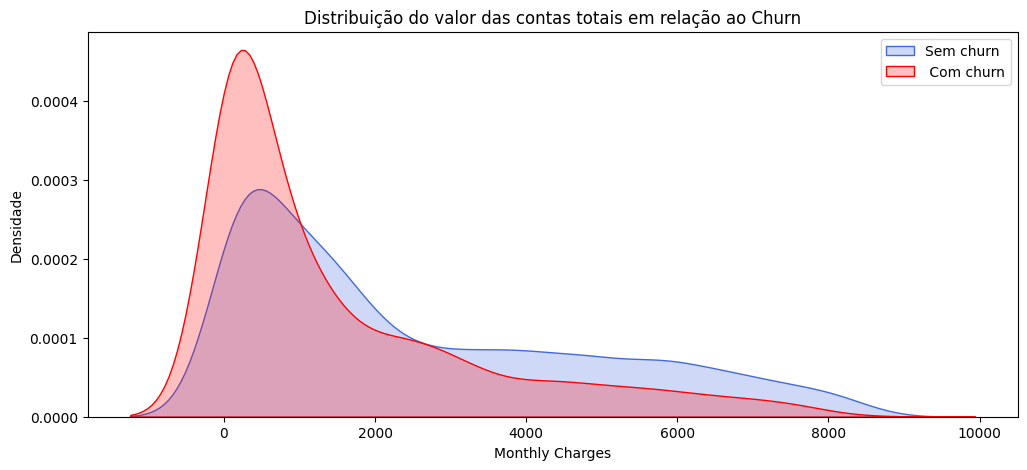

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(12, 5))
ax = sns.kdeplot(df_n.ChargesTotal[(df_n['Churn']=='No')],
                 color='royalblue', shade = True)

ax = sns.kdeplot(df_n.ChargesTotal[(df_n['Churn']=='Yes')],
                 color='red', shade = True)

ax.legend(["Sem churn"," Com churn"],loc='upper right')
ax.set_ylabel('Densidade')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribuição do valor das contas totais em relação ao Churn');

## Taxa de churn pelo produto OnlineSecurity

Esta é uma das colunas que estava em evidência na correlação positiva do churn quando o valor dela era "No".

Aqui podemos ver que para os clientes sem churn, está quase igualmente distribuído na casa dos 33%, enquanto para clientes com churn o fato de não ter o produto OnlineSecurity acusa 78% do total destes clientes.

Como é o fato de não ter um produto, não consigo afirmar que a falta dele realmente impacta ou é uma coincidência. Se fosse o contrário, poderíamos afirmar que é um produto ruim ou caro e está gerando churn, mas não é o caso.


In [ ]:
churn_online_security = round(df_n.groupby('Churn')['OnlineSecurity'].value_counts(normalize=True).mul(100).reset_index(name='Percentual'),2).sort_values(by='OnlineSecurity')
fig = px.bar(churn_online_security, x='OnlineSecurity', y='Percentual', color='Churn', barmode='group')
fig.update_layout(title='Taxa de Churn pelo produto OnlineSecurity', title_x=0.5, autosize=False, width=1200, height=500)
fig.show()

## Taxa de churn pelo produto TechSupport

Esta é uma das colunas que estava em evidência na correlação positiva do churn quando o valor dela era "No".

Aqui tenho a mesma conclusão do item anterior. O fato de não ter o produto ter um churn de 77% pode ser apenas um coincidência.

In [ ]:
churn_tech_support = round(df_n.groupby('Churn')['TechSupport'].value_counts(normalize=True).mul(100).reset_index(name='Percentual'),2).sort_values(by='TechSupport')
fig = px.bar(churn_tech_support, x='TechSupport', y='Percentual', color='Churn', barmode='group')
fig.update_layout(title='Taxa de Churn pelo produto TechSupport', title_x=0.5, autosize=False, width=1200, height=500)
fig.show()

## Taxa de churn pelo tipo de serviço de internet

Fato interessante aqui, o serviço de internet do tipo fibra óptica que é mais moderno e possui altas velocidades possui mais churn do que o antigo DSL.

Isso pode ilustrar que o serviço oferecido na fibra óptica pode estar ruim. Essa tecnologia tem maior capacidade de receber clientes e entrega velocidades superiores, mas pode estar ocorrendo algo nesta companhia que faça esse serviço ser pior que o DSL.

In [ ]:
churn_internet_service = round(df_n.groupby('Churn')['InternetService'].value_counts(normalize=True).mul(100).reset_index(name='Percentual'),2).sort_values(by='InternetService')
fig = px.bar(churn_internet_service, x='InternetService', y='Percentual', color='Churn', barmode='group')
fig.update_layout(title='Taxa de Churn pelo tipo de InternetService', title_x=0.5, autosize=False, width=1200, height=500)
fig.show()

## Distribuição de todas variáveis categóricas pelo churn em quantidade

Etapa criada para não ter que explorar coluna a coluna, mesmo as que não tinham influência no churn quando feita a correlação anteriormente.

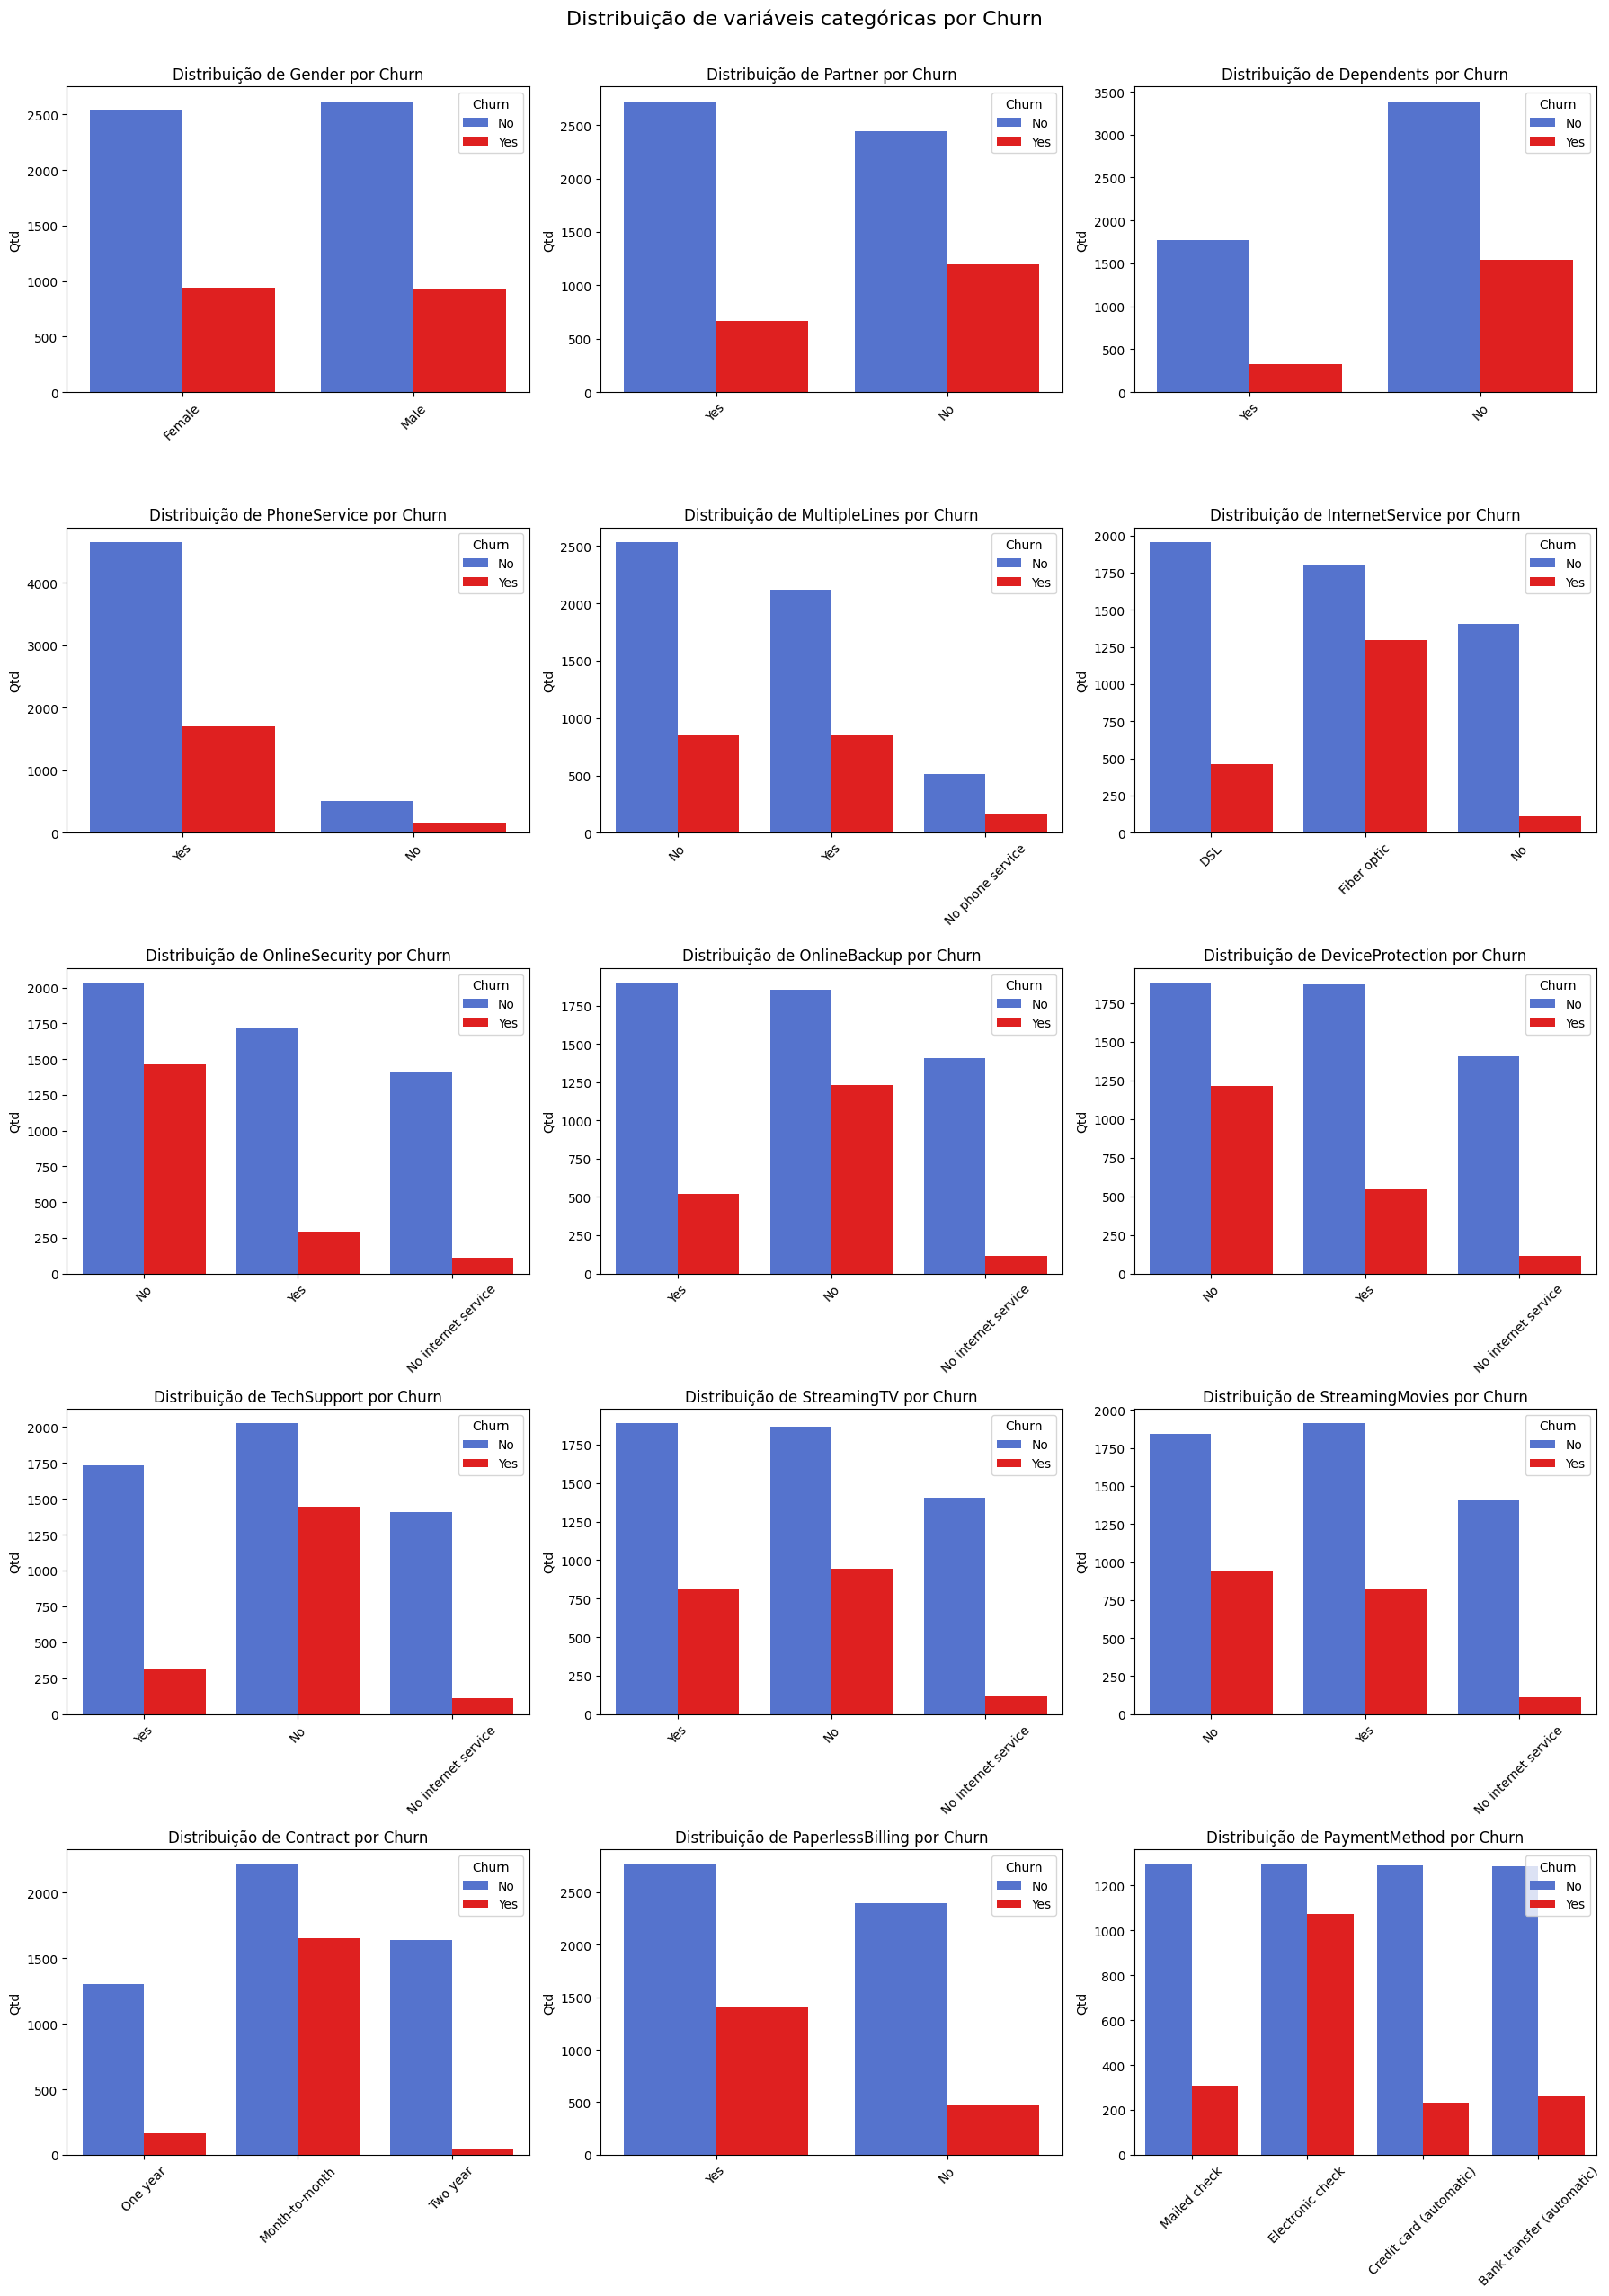

In [ ]:
colunas = [
    'Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

n_colunas = 3
n_linhas = -(-len(colunas) // n_colunas)  # Divide com arredondamento pra cima

plt.figure(figsize=(18, 5 * n_linhas))

for i, col in enumerate(colunas, 1):
    plt.subplot(n_linhas, n_colunas, i)
    sns.countplot(data=df_n, x=col, hue='Churn', palette=['royalblue', 'red'])
    plt.title(f'Distribuição de {col} por Churn')
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('Qtd')
    plt.tight_layout()

plt.suptitle('Distribuição de variáveis categóricas por Churn', fontsize=16, y=1.02)
plt.show()


In [ ]:
colunas = ['Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod']

for col in colunas:
    print(f'\n Distribuição de Churn para: {col}')
    display(df_n.groupby([col, 'Churn']).size().unstack(fill_value=0))


 Distribuição de Churn para: Gender


Churn,No,Yes
Gender,,
Female,2544,939
Male,2619,930



 Distribuição de Churn para: Partner


Churn,No,Yes
Partner,,
No,2439,1200
Yes,2724,669



 Distribuição de Churn para: Dependents


Churn,No,Yes
Dependents,,
No,3390,1543
Yes,1773,326



 Distribuição de Churn para: PhoneService


Churn,No,Yes
PhoneService,,
No,510,170
Yes,4653,1699



 Distribuição de Churn para: MultipleLines


Churn,No,Yes
MultipleLines,,
No,2536,849
No phone service,510,170
Yes,2117,850



 Distribuição de Churn para: InternetService


Churn,No,Yes
InternetService,,
DSL,1957,459
Fiber optic,1799,1297
No,1407,113



 Distribuição de Churn para: OnlineSecurity


Churn,No,Yes
OnlineSecurity,,
No,2036,1461
No internet service,1407,113
Yes,1720,295



 Distribuição de Churn para: OnlineBackup


Churn,No,Yes
OnlineBackup,,
No,1854,1233
No internet service,1407,113
Yes,1902,523



 Distribuição de Churn para: DeviceProtection


Churn,No,Yes
DeviceProtection,,
No,1883,1211
No internet service,1407,113
Yes,1873,545



 Distribuição de Churn para: TechSupport


Churn,No,Yes
TechSupport,,
No,2026,1446
No internet service,1407,113
Yes,1730,310



 Distribuição de Churn para: StreamingTV


Churn,No,Yes
StreamingTV,,
No,1867,942
No internet service,1407,113
Yes,1889,814



 Distribuição de Churn para: StreamingMovies


Churn,No,Yes
StreamingMovies,,
No,1843,938
No internet service,1407,113
Yes,1913,818



 Distribuição de Churn para: Contract


Churn,No,Yes
Contract,,
Month-to-month,2220,1655
One year,1306,166
Two year,1637,48



 Distribuição de Churn para: PaperlessBilling


Churn,No,Yes
PaperlessBilling,,
No,2395,469
Yes,2768,1400



 Distribuição de Churn para: PaymentMethod


Churn,No,Yes
PaymentMethod,,
Bank transfer (automatic),1284,258
Credit card (automatic),1289,232
Electronic check,1294,1071
Mailed check,1296,308


# Relatório final

O trabalho foi dividido em vários tópicos, sendo que no tópico Problema foi apresentado uma explicação sobre o que é o churn e o objetivo deste trabalho. Abaixo detalho os outros tópicos.

## Limpeza e tratamento de dados:
Nesta etapa foi analisado todo o dataset que inicialmente estava em arquivo json, sendo necessário tratativa para normalizar e unificar as informações. Posteriormente foi feita tratativa de nulos, valores vazios '' e tipos de dados incorretos. Esta etapa é essencial para uma análise efetiva dos dados.

## Análise exploratória de dados:
Esta etapa foi iniciada com um gráfico de correlação do churn pela categoria de cada variável categória. Esta etapa ajudou muito na pré investigação dos dados, pois foi possível identificar quais categorias tem mais e menos relação com o chun. Ex: A variável Contract com valor Month-to-month tem a maior relação positiva com o churn, enquanto quando essa variável tem valor igual a Two year, possui uma das maiores relações negativas com o churn. Posteriormente foram feitas análises de churn em cima das variáveis categóricas que mais chamaram atenção e em cima das quatro variáveis numéricas. Os resultados dessa avaliação deu os insumos necessários para as conclusões e insights e podem ser conferidas anteriormente.

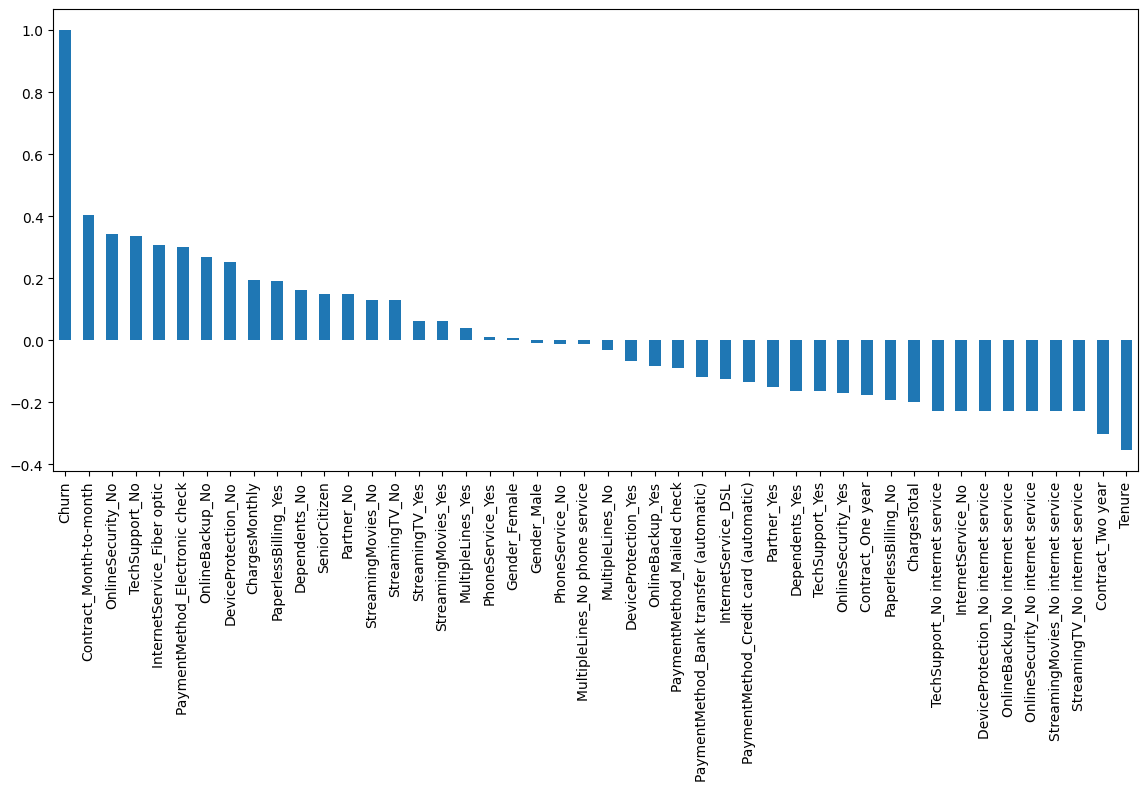



## Conclusões e insights:
Baseado na análise anterior, temos:

1.   Contratos mês a mês tem alta incidência de churn, enquanto contratos de um e dois anos tem baixa incidência.
  **Ação**: Focar em campanhas e produtos que possam, de alguma forma, fidelizar o cliente por mais tempo.
  Empresas de telecom do Brasil costumam vincular o empréstimo de equipamentos ou preços especiais à contratos de 1 ano ou mais, além de ter multas caso o cliente queira evadir antes do contrato acabar.
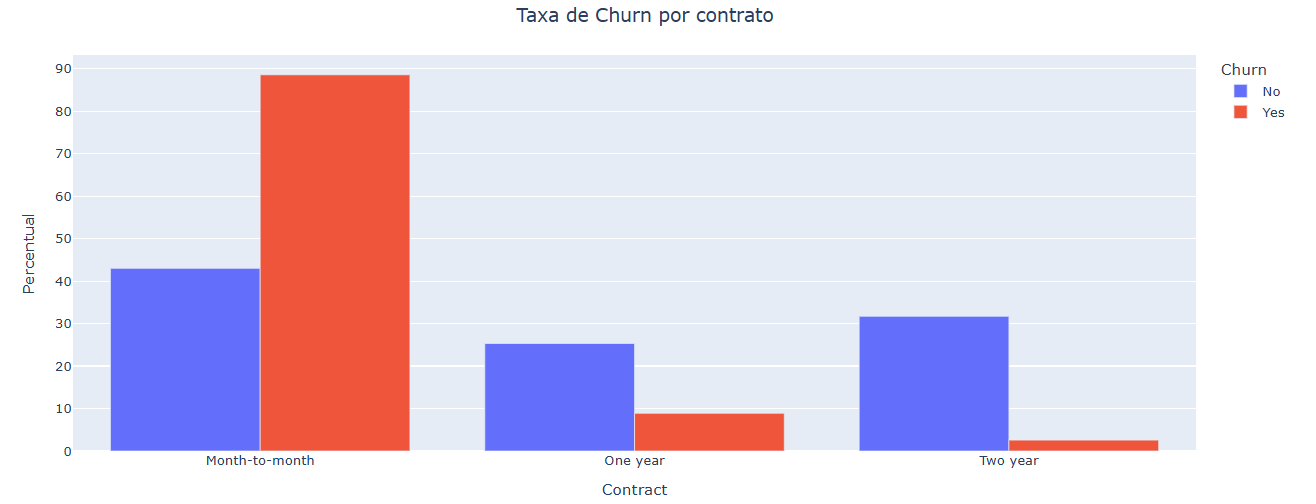

2.   Diretamente ligado ao contrato, o tempo de casa (tenure), também é um grande fator no churn, quanto menos tempo de casa mais suscetível ao churn o cliente é.
  **Ação**: Aqui a empresa parece que já atua bem, mas algo que é importante e muitas vezes é deixado de lado pelas empresas de telecom é dar benefícios e bons preços aos clientes antigos.
  Não é raro encontrar um cliente antigo com um plano pior e mais caro que um cliente novo. Portanto, olhar para esses clientes de tempos em tempos, pode ajudar a manter eles na base.
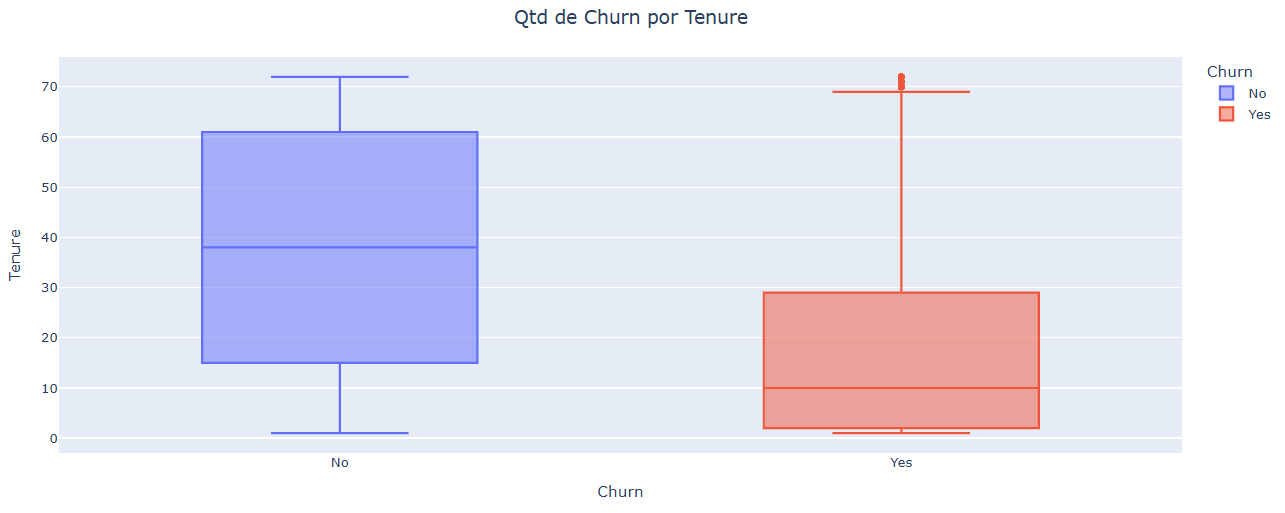  

3.   O valor das constas mensais também está bastante correlacionado ao churn. Quanto mais alta as contas, maior risco de churn.
  **Ação**: Revisitar planos antigos, conforme mencionado anteriormente. Equalizar preços com concorrentes oferecendo bônus ou melhorias em relação aos planos atuais.
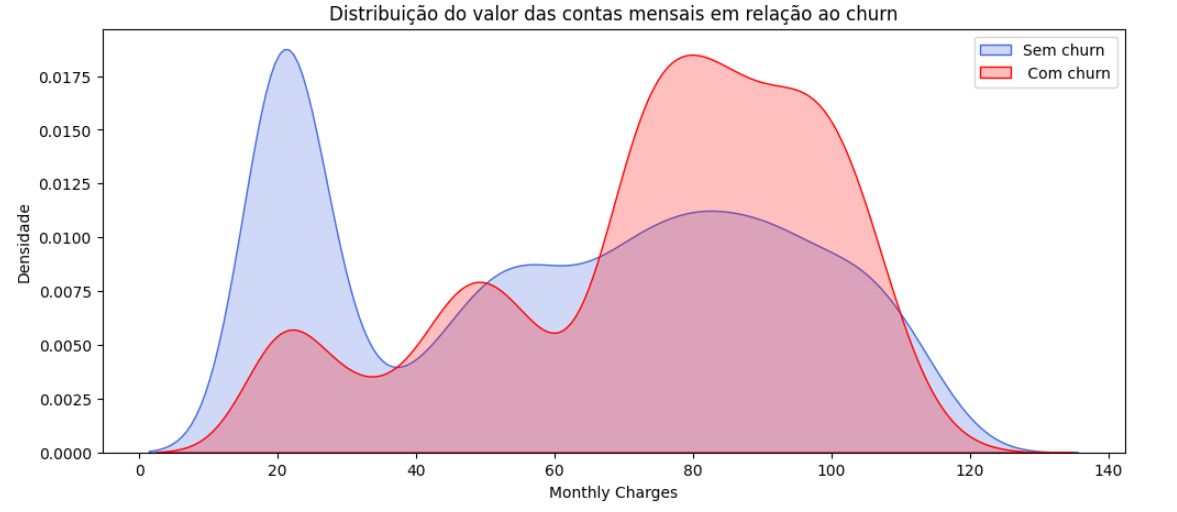  

4.   O tipo de internet utilizada chamou bastante atenção, pois a conexão por fibra óptica representa 35% da base de clientes, mas é responsável por 69% dos casos de churn. Trata-se de uma tecnologia que oferece velocidades de transferência de dados muito superiores à DSL, com maior capacidade para atender mais usuários e com expansão cada vez mais facilitada.
  **Ação**: Conversar com o time de engenharia e capacidade da empresa para verificar como está a saúde dos pontos de acesso entregues. Não é incomum empresas de telecom fazerem campanhas agressivas e admitir mais clientes do que elas comportam, gargalando os equipamentos e links. Dependendo do local do gargalo, todos clientes de uma cidade ou região podem ser afetados.
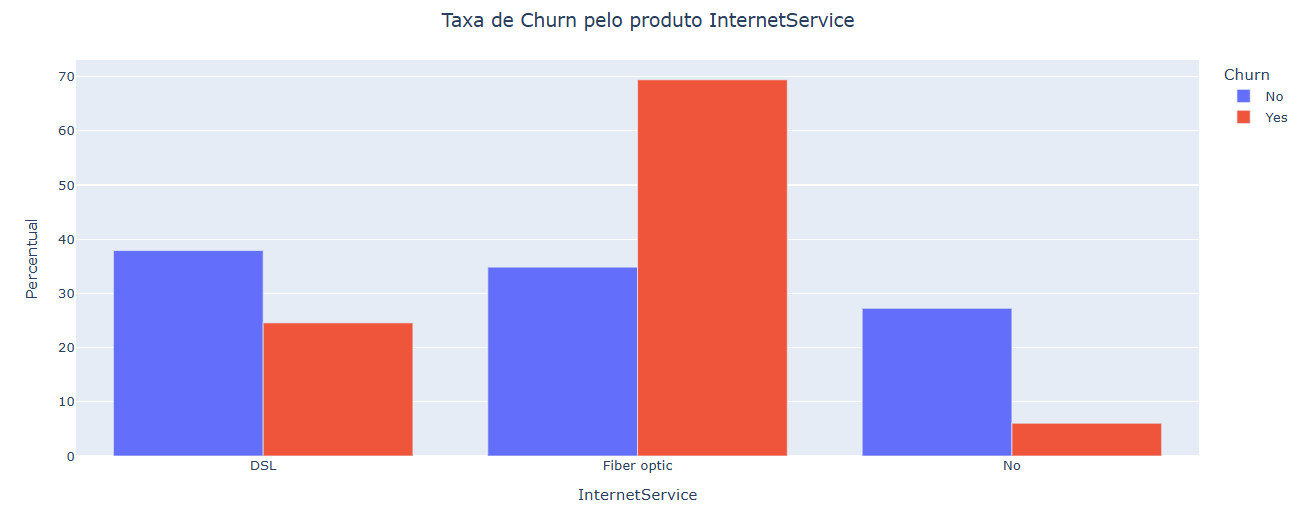

5.  O fato dos clientes não terem o produto OnlineSecurity deu correlação positiva com o churn. Entretanto, acredito que é apenas um coincidência, pois é a ausência de um produto bem específico. Para ter certeza, precisaria de mais dados do produto para realizar uma investigação mais aprofundada.

## Próximos passos:
Este dataset é muito interessante para se avançar em análises mais complexas com modelos de machine learning. Quando tiver mais conhecimento sobre o tema, irei revisitar o item para explorar outras formas de identificar os possíveis causadores do churn.


